In [1]:
curr_box = 'Box_n50_0_1400'
jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+curr_box+'_jackknife_covs.pkl'
NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+curr_box+'_NvsM.pkl'


In [2]:
import pickle
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()


NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f)
NvM_f.close()

In [3]:
import numpy as np
curr_a = list(jackknife.keys())[0]
curr_var = np.diag(jackknife[curr_a][1])

In [4]:
NvMs[curr_a].keys()

dict_keys(['M', 'N', 'vol', 'Mpart', 'edge_pairs', 'bin_idx', 'corrections'])

In [5]:
curr_N = NvMs[curr_a]['N']
curr_M = np.array(NvMs[curr_a]['M'])

curr_edge_pairs = NvMs[curr_a]['edge_pairs']

In [6]:
import pyccl as ccl
from aemulusnu_hmf.emulator import get_cosmology


h = 0.6724
cosmology = {'ns': 0.97,
 'H0': h * 100,
 'w0': -1.0,
 'ombh2': 0.0223,
 'omch2': 0.12,
 'nu_mass_ev': 0.07,
 '10^9 As': 2.1}
hmf_cosmology = get_cosmology(cosmology)

cosmo = ccl.Cosmology(Omega_b=cosmology['ombh2']/h**2, 
                      Omega_c=cosmology['omch2']/h**2, 
                      h=h, 
                      A_s=cosmology['10^9 As'] * 1e-9, 
                      n_s=cosmology['ns'])

halo_bias = ccl.halos.HaloBiasTinker10()
bh = halo_bias(cosmo, curr_M / h, a=curr_a)

initializing cosmology. this will only happen once per cosmology


In [7]:
def integrand_vectorized(logkx, logky, logkz):
#     print(logkx, logky, logkz)
    kx = np.exp(logkx)
    ky = np.exp(logky)
    kz = np.exp(logkz)
    k = np.sqrt(kx**2 + ky**2 + kz**2)

    z=1/curr_a - 1
    
    oup = 1/(2*np.pi)**3 
    
    for ki in [kx, ky, kz]:
        arg = ki * 1050 / 2
        oup *= (np.sin(arg) / arg) **2
    return oup * kx * ky * kz

# 

import cProfile
cProfile.run('integrand_vectorized(-1, -1, -1)')

         4 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 3191146979.py:1(integrand_vectorized)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




$$n(M;x,z) = \bar n  + \delta n = \bar n(1 + b \delta) $$
window function is a cube 
$$n(M,z) = \int d^3 x \frac 1 {\rm vol} \times n(M;x,z) $$
$${\rm var}(n(M,z)) = b^2 \bar n^2 \int_{\vec k} P(k) \prod_{i=x,y,z} {\rm sinc}^2(k_i L / 2) $$

In [20]:
from tqdm import trange
logkleft = -20
logkright = 3

n_samps = 100
z=1/curr_a - 1

logkx = np.linspace(logkleft, logkright, n_samps)
logky = np.linspace(logkleft, logkright, n_samps)
logkz = np.linspace(logkleft, logkright, n_samps)

dlogkx = logkx[1] - logkx[0]
dlogky = logky[1] - logky[0]
dlogkz = logkz[1] - logkz[0]
    
logKX, logKY, logKZ = np.meshgrid(logkx, logky, logkz, indexing='ij')
F = integrand_vectorized(logKX, logKY, logKZ)
for i in trange(n_samps):
    for j in range(n_samps):
        for k in range(n_samps):
            kk = np.sqrt(np.exp(logKX[i,j,k])**2 + np.exp(logKY[i,j,k])**2 + np.exp(logKZ[i,j,k])**2)
            F[i,j,k] *= hmf_cosmology.pkclass.pk_cb_lin(kk * hmf_cosmology.h, z) * hmf_cosmology.h ** 3
    
F[0,:,:] *= 0.5
F[-1,:,:] *= 0.5
F[:,0,:] *= 0.5
F[:,-1,:] *= 0.5
F[:,:,0] *= 0.5
F[:,:,-1] *= 0.5

integral = np.sum(F) * dlogkx * dlogky * dlogkz



100%|██████████| 100/100 [00:09<00:00, 10.64it/s]


In [21]:
from scipy.integrate import tplquad

mbox = 1050**3 * hmf_cosmology.f_rho_cb(0.0)
sigma_cb = hmf_cosmology.sigma_cb(mbox, z=1/curr_a - 1)

sample_variance = bh**2 * curr_N**2 
sample_variance *= integral * 8
# factor of 8 bc used symmetry to change int_-inf^inf -> 2 * int_0^inf for dkx, dky, and dkz

In [22]:
curr_bin_edges = [pair[0] for pair in curr_edge_pairs]

[]

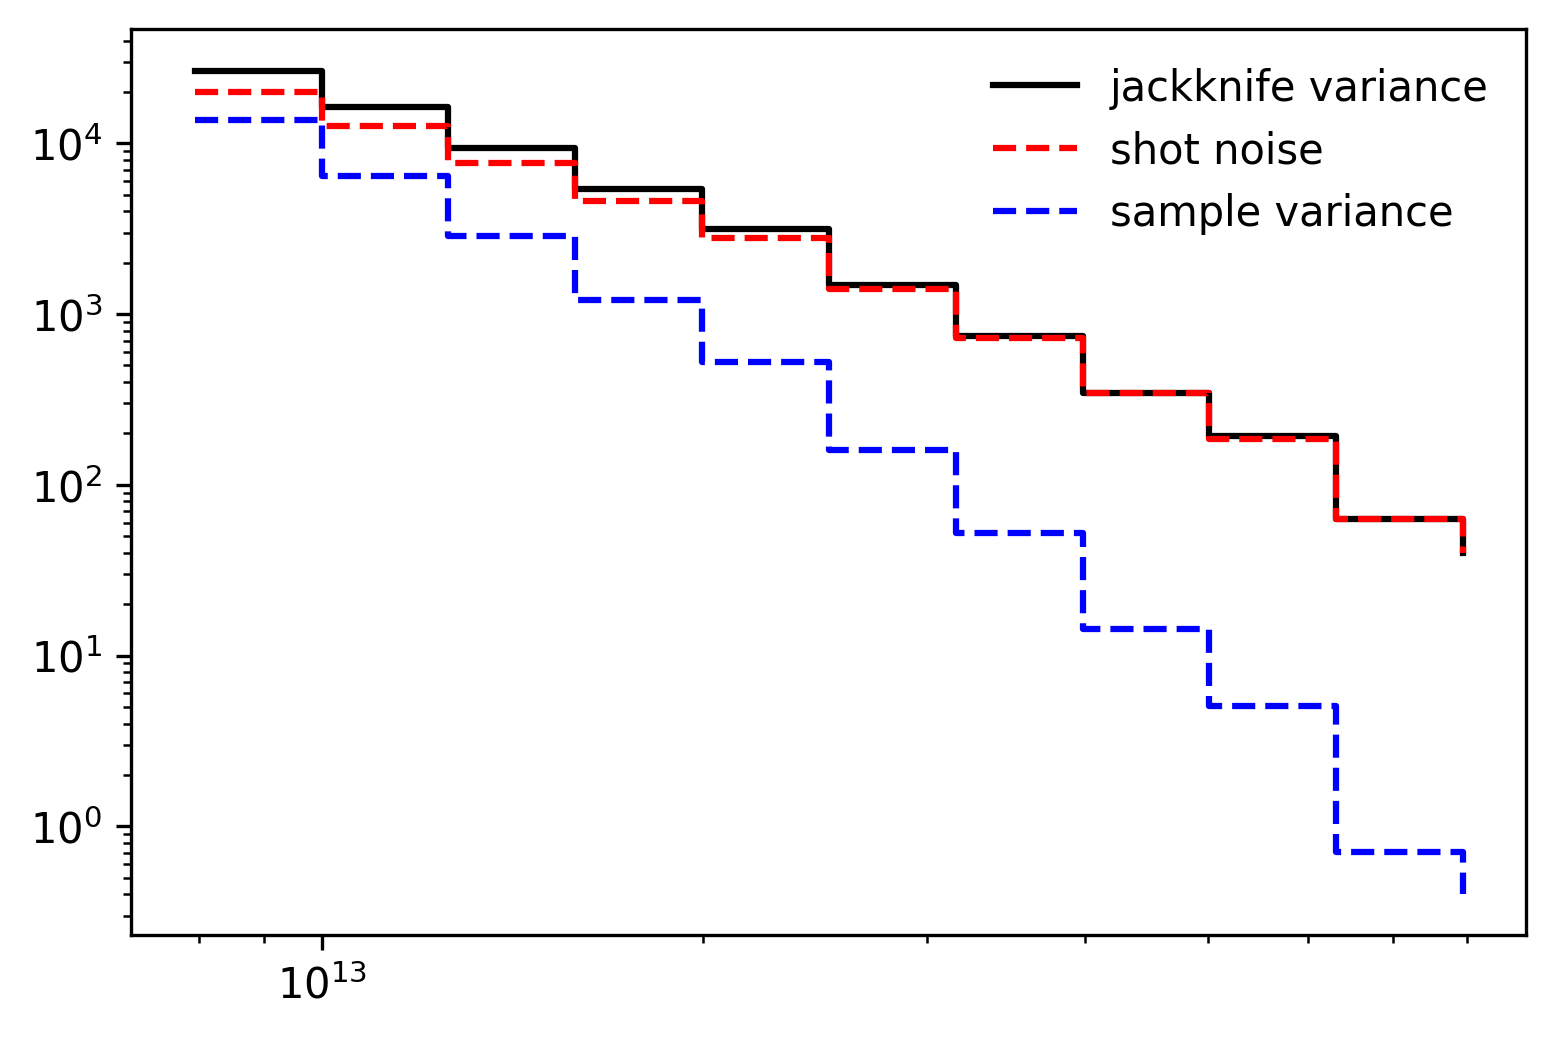

In [23]:
import matplotlib.pyplot as plt
plt.figure(dpi = 300, facecolor = 'w')


plt.step(curr_bin_edges, curr_var,
             where='post', label=r'jackknife variance', c='k', ls='-')

plt.step(curr_bin_edges, curr_N,
             where='post', label=r'shot noise', c='r', ls='--')
plt.step(curr_bin_edges, (sample_variance),
             where='post', label=r'sample variance', c='b', ls='--')
# plt.step(curr_bin_edges, (sample_variance) + curr_N,
#              where='post', label=r'sample variance + shot noise', c='g', ls='-')


plt.legend(frameon = False)
plt.loglog()